# Tarea 5

In [1]:
import pandas as pd
import numpy as np

from dotenv import load_dotenv
import os

In [2]:
load_dotenv()
smm2_df = pd.read_csv(os.getenv("DATASET_STORE_FILE"))
columns_to_drop = ['data_id', 'name', 'description', 'gamestyle', 'theme', 'tag1', 'tag2', 'clear_condition', 'clear_condition_magnitude', 'weekly_likes', 'weekly_plays', 'uploader_pid', 'first_completer_pid', 'record_holder_pid']
smm2_df_clean = smm2_df.drop(columns_to_drop, axis=1)
smm2_df_clean['unique_clear_rate'] = np.minimum(smm2_df_clean['clears'] / smm2_df_clean['unique_players_and_versus'], 1.0)
smm2_df_clean.head(5)

,uploaded,created,difficulty,game_version,world_record,upload_time,upload_attempts,num_comments,timer,autoscroll_speed,clears,attempts,clear_rate,plays,versus_matches,coop_matches,likes,boos,unique_players_and_versus,unique_clear_rate
0,1621061069,1621092960,2,5,15283,15266,1,0,20,0,23,396,5.808081,45,0,0,3,2,38,0.605263
1,1621077412,1621080840,1,5,47217,62592,1,0,500,0,16,59,27.118644,26,0,0,1,1,24,0.666667
2,1621051239,1621033080,1,5,53933,57333,1,0,200,0,1,12,8.333333,4,0,0,0,0,4,0.250000
3,1621064079,1620710520,1,5,223387,198789,1,1,500,0,6,59,10.169492,22,0,0,1,0,21,0.285714
4,1621059182,1620229080,0,5,20533,32690,3,2,300,0,84,160,52.500000,95,2,0,13,4,86,0.976744


## Agrupación

A diferencia de k-medias, el análisis de arquetipos forma grupos con los valores mas extremos de los mismos, esto lo hace encontrando las esquinas de la envoltura convexa de los datos. Gracias a esto, es mas sencillo encontrar lo que diferencía a los distintos grupos de datos.<br>
Matematicamente, lo que trata de hacer el análisis de arquetipos es minimizar la formula $\lVert X - C Z \rVert$, donde $X \in \mathbb{R}^{N \times d}$ es la matriz con los datos, $Z \in \mathbb{R}^{k \times d}$ es la matriz con los arquetipos, $C \in \mathbb{R}^{N \times k}$ es la matriz de coeficientes de $X$ y $Z$, $N$ es la cantidad de muestras, $d$ es la cantidad de dimensiones de las muestras y $k$ es la cantidad de arquetipos.<br>
Decidí usar esta tecnica debido a que el articulo [A Comparison of Methods for Player Clustering via Behavioral Telemetry](https://arxiv.org/pdf/1407.3950) la utilizó junto con k-medias para clusterizar datos generados por jugadores. Y obtuve una definición mas concreata del análisis de arquetipos del artículo [Deciphering Data Extremes: A Practitioner’s Guide to Archetypal Analysis](https://medium.com/aimonks/deciphering-data-extremes-a-practitioners-guide-to-archetypal-analysis-9814d25446f8)<br>
<br>
Nota: NO recomiendo usar [Freedium](https://freedium.cfd) para leer el articulo de Medium, ya que eso sería piratería, y la piratería es ilegal.

In [ ]:
from sklearn.preprocessing import StandardScaler
from archetypes import AA
import matplotlib.pyplot as plt

In [103]:
scaler = StandardScaler()

# Nota: la muestra ya esta en un orden aleatorio, por lo que simplemente agarrar 
# los primeros x elementos no debería de generar un problema en el análisis
X = scaler.fit_transform(smm2_df_clean[['upload_attempts', 'clear_rate']].head(1_000))
y = smm2_df_clean[['difficulty']].head(1_000).values

aa = AA(n_archetypes=3, max_iter=1_000)
X_trans = aa.fit_transform(X)

In [104]:
X_unscaled = scaler.inverse_transform(X)
arch_unscaled = scaler.inverse_transform(aa.archetypes_)

In [107]:
arch_unscaled

array([[  1.00559355,  99.99716314],
       [217.        ,   0.        ],
       [  1.01409338,   1.71004534]])

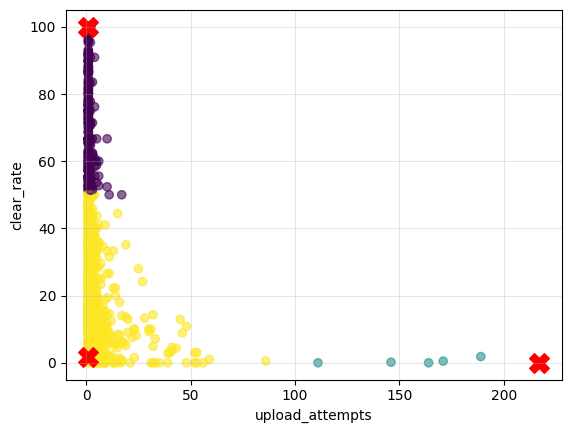

In [105]:
labels = np.argmax(X_trans, axis=1)

plt.scatter(X_unscaled[:,0], X_unscaled[:,1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(arch_unscaled[:,0], arch_unscaled[:,1], c='red', marker='X', s=200)
# plt.title("Archetypal Analysis Clustering")
plt.xlabel('upload_attempts')
plt.ylabel('clear_rate')
plt.grid(True, alpha=0.3)
plt.show()

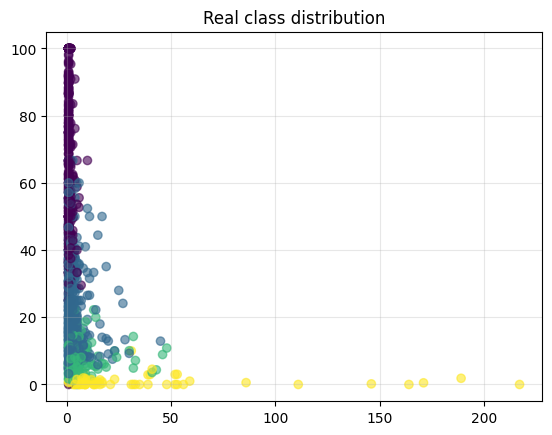

In [78]:
plt.scatter(X_unscaled[:,0], X_unscaled[:,1], c=y, cmap='viridis', alpha=0.6)
plt.title("Real class distribution")
plt.grid(True, alpha=0.3)
plt.show()

### Cantidad optima de grupos

Se usará el método de silueta para elegir la cantidad de grupos. Se calcula el coeficiente de silueta para cada número de grupos, y el que tenga el mayor coeficiente es elegido. La formula del coeficiente de silueta es:<br>
$$
s(i) = \frac{b(i) - a(i)}{\max\{a(i),\, b(i)\}}
$$
Donde $b(i)$ es la ditancia promedio entre el punto i y los puntos del cluster vecino mas cercano, y $a(i)$ es la distancia promedio del punto i a los demas puntos de su cluster.<br>
Obtube la información del articulo [How many clusters?](https://medium.com/data-science/how-many-clusters-6b3f220f0ef5)

In [ ]:

from sklearn.metrics import silhouette_score

In [95]:
iter_quant = 1
sil_scores = []
for i in range(2, 8):
    group_scores = []
    for _ in range(iter_quant):
        i_aa = AA(n_archetypes=i)
        i_W = i_aa.fit_transform(X)
        score = silhouette_score(X, np.argmax(i_W, axis=1))
        group_scores.append(score)
    sil_scores.append(np.mean(group_scores))
    

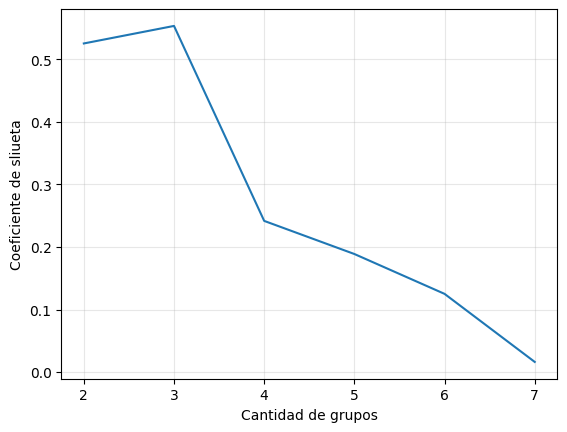

In [106]:
plt.plot(range(2, len(sil_scores) + 2), sil_scores)
plt.xlabel('Cantidad de grupos')
plt.ylabel('Coeficiente de sliueta')
plt.grid(True, alpha=0.3)
plt.show()